In [1]:
from gel import *
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from sanity_utils import *
import ufl

custom_plt_style()

# Obtaining Data

Data for the test cases is publicly available TODO

In [ ]:
%cd YOUR_DATA_DIR_HERE

# Test Cases

## Perfect Displacement Information

Generate target displacements:

    mpirun -n 2 forward -c cell_data_A -a exact_target_test/beta_tar.xdmf --bci cell_data_A/bci.vtk --bco cell_data_A/bco.vtk -l 2

Alternatively, use "exact_target_test/u_exact.xdmf"

Run stage 1 of inverse model:

    nohup mpirun -n 2 inverse -r perfect_u_results -c cell_data_A -t forward/A-beta-beta_tar.xdmf-1-hypre_amg-2-None-n2.0-20.0-bci.vtk-bco.vtk/u_full_shape.xdmf -g 10.0 --bci cell_data_A/bci.vtk --bco cell_data_A/bco.vtk | tee -a out.txt &

Stage 2 (note the -i argument can be changed to the output of the previous stage instead of the original run):

    nohup mpirun -n 2 inverse -r perfect_u_results -c cell_data_A -t forward/A-beta-beta_tar.xdmf-1-hypre_amg-2-None-n2.0-20.0-bci.vtk-bco.vtk/u_full_shape.xdmf -i perfect_u_results/A-beta-True-zero-1-10.0-u_metric-tikhonov-exclude_undetectable-entire_gel-0.38-False-None-n2.0-20.0-1en08-hypre_amg-bci.vtk-bco.vtk/mod_repr_full_shape.xdmf -g 0.001 --bci cell_data_A/bci.vtk --bco cell_data_A/bco.vtk | tee -a out.txt &

Stage 3 (note the -i argument can be changed to the output of the previous stage instead of the original run):

    nohup mpirun -n 2 inverse -r perfect_u_results -c cell_data_A -t forward/A-beta-beta_tar.xdmf-1-hypre_amg-2-None-n2.0-20.0-bci.vtk-bco.vtk/u_full_shape.xdmf -i perfect_u_results/A-beta-True-mod_repr_full_shape.xdmf-1-0.001-u_metric-tikhonov-exclude_undetectable-entire_gel-0.38-False-None-n2.0-20.0-1en08-hypre_amg-bci.vtk-bco.vtk/mod_repr_full_shape.xdmf -g 0.0 --rt no_regularization --opt-backend scipy --bci cell_data_A/bci.vtk --bco cell_data_A/bco.vtk | tee -a out.txt &

We will also want to compare with displacements from assuming homogeneous modulus, we can reuse the forward result from the previous section.

Alternatively, use the results given in exact_target_test.

Analysis:

In [3]:
cell_data_dir = f"cell_data_A"
geo = Geometry(
    cell_data_dir,
    u_magnitude_subdomains_file=os.path.join(
        "exact_target_test",
        "u_exact.xdmf"
    )
)

In [4]:
beta_sim = load_shape(geo.V0, "exact_target_test/beta_sim3.xdmf", "mod_repr")
beta_tar = load_shape(geo.V0, "exact_target_test/beta_tar.xdmf", "mod_repr")

In [5]:
avg_rel_mod_err = np.exp(assemble((abs(beta_sim - beta_tar))*geo.dx)/assemble(1*geo.dx)) - 1
print(f"Average relative modulus error: {100*avg_rel_mod_err}%")

Average relative modulus error: 1.0580048792049546%


In [6]:
kin_tar = kinematics_from_file(geo, os.path.join("exact_target_test/u_exact.xdmf"))
kin_sim = kinematics_from_file(geo, os.path.join("exact_target_test/u_sim3.xdmf"))

u_tar = kin_tar.u.vector().get_local().reshape(-1, 3)
u_sim = kin_sim.u.vector().get_local().reshape(-1, 3)

In [7]:
max_u_err = np.linalg.norm(u_tar - u_sim, axis=-1).max()
print(f"Maximum nodal displacement error: {max_u_err} um")

Maximum nodal displacement error: 0.042575980651170686 um


In [8]:
kin_uni = kinematics_from_file(geo, "real_mvic_data/A_homogeneous/full_shape/u_cg2.xdmf")
u_uni = kin_uni.u.vector().get_local().reshape(-1, 3)
u_diff_with_homog = np.linalg.norm(u_tar - u_uni, axis=-1).max()
print(f"Target vs. homogeneous assumption max nodal u difference: {u_diff_with_homog} um")

Target vs. homogeneous assumption max nodal u difference: 3.052572240062031 um


## Noisy Displacement Information

Generate ground truth displacements on finer mesh:

    mpirun -n 2 forward -c cell_data_A_finer -a noisy_target_test/beta_tar.xdmf --bci cell_data_A_finer/bci.vtk --bco cell_data_A_finer/bco.vtk -l 2

Obtain helper mesh with event horizon info:

    get_veh -c cell_data_A -i noisy_target_test/u_exp_1000.xdmf -o noisy_target_test

Alternatively, use the data in noisy_target_test.

Sample at real bead positions, add realistic noise distribution:

In [9]:
test_dir = "noisy_target_test"

In [10]:
geo_tar = Geometry("cell_data_A_finer")
kin_tar = kinematics_from_file(geo_tar, os.path.join(test_dir, "u_tar_finer_full_shape/u_cg2.xdmf"))

In [11]:
pm_bead_mesh = meshio.read(os.path.join(test_dir, "pm_bead_filtering.vtk"))
orig_beads = meshio.Mesh(pm_bead_mesh.points[pm_bead_mesh.point_data["admit"].astype(bool)], {})

In [12]:
u_gt = kin_tar.u
u_gt.set_allow_extrapolation(True)

In [13]:
u_at_beads = np.zeros_like(orig_beads.points)
for i, x in enumerate(orig_beads.points):
    u_at_beads[i] = u_gt(x)

Building point search tree to accelerate distance queries.
Computed bounding box tree with 1824289 nodes for 912145 points.


In [14]:
synth_bead_data = meshio.Mesh(orig_beads.points, {}, point_data={"u_exact" : u_at_beads})
noise_lvls = np.loadtxt(os.path.join(test_dir, "noise_lvls.txt"))
noise = np.zeros_like(orig_beads.points)
noise[:,0] = np.random.normal(0.0, noise_lvls[0], len(orig_beads.points))
noise[:,1] = np.random.normal(0.0, noise_lvls[1], len(orig_beads.points))
noise[:,2] = np.random.normal(0.0, noise_lvls[2], len(orig_beads.points))
u_noisy = u_at_beads + noise
synth_bead_data.point_data["u_noisy"] = u_noisy

In [15]:
alpha_stiff_amp = 1000

# Enable this to write the data, or just use the data provided
if False:
    synth_bead_data.write(os.path.join(test_dir, f"synth_beads_{alpha_stiff_amp}_nic.vtk"))
    np.savetxt(os.path.join(test_dir, f"bead_init_{alpha_stiff_amp}_nic.txt"), synth_bead_data.points)
    np.savetxt(os.path.join(test_dir, f"bead_u_{alpha_stiff_amp}_nic.txt"), u_noisy)

Go to fmtrack_environment_analysis.ipynb for fitting the GPR model and generating noisy target displacements.

Estimating induced difference in $J$ by comparing against the exact target test's $J$:

In [16]:
cell_data_dir = "cell_data_A"
geo = Geometry(cell_data_dir, u_magnitude_subdomains_file=os.path.join(test_dir, "u_exp_1000.xdmf"))

In [17]:
kin_tar_with_noise = kinematics_from_file(geo, os.path.join(test_dir, "u_exp_1000.xdmf"))
kin_tar = kinematics_from_file(geo, "exact_target_test/u_exact.xdmf")

In [18]:
J_tar_with_noise = kin_tar_with_noise.projected_J
J_tar = kin_tar.projected_J

In [19]:
mean_J_diff = (np.abs(J_tar.vector().get_local() - J_tar_with_noise.vector().get_local())/J_tar.vector().get_local()).mean()
print(f"Mean difference in J: {mean_J_diff}")

Mean difference in J: 0.008801301158031712


## Matching Compressibility

Run inverse model:

    nohup mpirun -n 2 inverse -r noisy_test_results -c cell_data_A -t noisy_target_test/u_exp_1000.xdmf --bci noisy_target_test/bci.vtk --bco noisy_target_test/bco.vtk | tee -a out.txt &

Obtain simulated kinematic quantities:

    get_kinematics_mesh -c cell_data_A -i noisy_target_test/u_sim.xdmf -o noisy_target_test/kinematics_sim.xdmf

Alternatively, use resuls given in noisy_target_test.

Analysis, continuing from the previous section:

In [20]:
kin_sim = kinematics_from_file(geo, os.path.join(test_dir, "u_full_shape.xdmf"))

In [21]:
beta_sim = load_shape(geo.V0, os.path.join(test_dir, "solved.xdmf"), "mod_repr")
beta_tar = load_shape(geo.V0, "exact_target_test/beta_tar.xdmf", "mod_repr")

In [22]:
mech_tar = Mechanics(kin_tar, mod_repr=beta_tar)
energy_tar = mech_tar.get_total_strain_energy()
print(f"Target energy: {energy_tar} pJ")

Target energy: 6.779966497780935 pJ


In [23]:
mech_sim = Mechanics(kin_sim, mod_repr=beta_sim)
energy_sim = mech_sim.get_total_strain_energy()
print(f"Predicted energy: {energy_sim} pJ")

Predicted energy: 5.29799452986719 pJ


In [24]:
# Volumes
stiff_vol_tar = assemble(ufl.conditional(ufl.gt(beta_tar, np.log(10)), 1.0, 0.0)*geo.dx)
stiff_vol_sim = assemble(ufl.conditional(ufl.gt(beta_sim, np.log(10)), 1.0, 0.0)*geo.dx)
print(f"Target stiffened volume: {stiff_vol_tar}")
print(f"Predicted stiffened volume: {stiff_vol_sim}")

Target stiffened volume: 50960.11442395354
Predicted stiffened volume: 51119.90794151884


In [25]:
deg_vol_tar = assemble(ufl.conditional(ufl.lt(beta_tar, np.log(0.99)), 1.0, 0.0)*geo.dx)
deg_vol_sim = assemble(ufl.conditional(ufl.lt(beta_sim, np.log(0.99)), 1.0, 0.0)*geo.dx)
print(f"Target degraded volume: {deg_vol_tar}")
print(f"Predicted degraded volume: {deg_vol_sim}")

Target degraded volume: 226319.10013583084
Predicted degraded volume: 215359.65407914663


In [26]:
veh_mesh = meshio.read(os.path.join(test_dir, "u_regions_0.38000000.vtu"))
veh_mask = np.zeros(len(veh_mesh.points), dtype=bool)
veh_mask[veh_mesh.cells[0].data[veh_mesh.cell_data["f"][0] == 251]] = True

In [27]:
# Read in sim
sim_xdmf = os.path.join(test_dir, "beta_sim_nodal.xdmf")
save_fenics_fcn_nodally(beta_sim, sim_xdmf, "mod_repr")
sim_mesh = nodal_values_to_meshio(sim_xdmf)
sim_points, sim_cells, sim_point_data, sim_cell_data = \
    sim_mesh.points, sim_mesh.cells, sim_mesh.point_data, sim_mesh.cell_data

In [28]:
# Read in tar
comparable_tar_xdmf = "noisy_target_test/beta_tar_nodal.xdmf"
save_fenics_fcn_nodally(beta_tar, comparable_tar_xdmf, "mod_repr")
tar_mesh = nodal_values_to_meshio(comparable_tar_xdmf)
tar_points, tar_cells, tar_point_data, tar_cell_data = \
    tar_mesh.points, tar_mesh.cells, tar_mesh.point_data, tar_mesh.cell_data

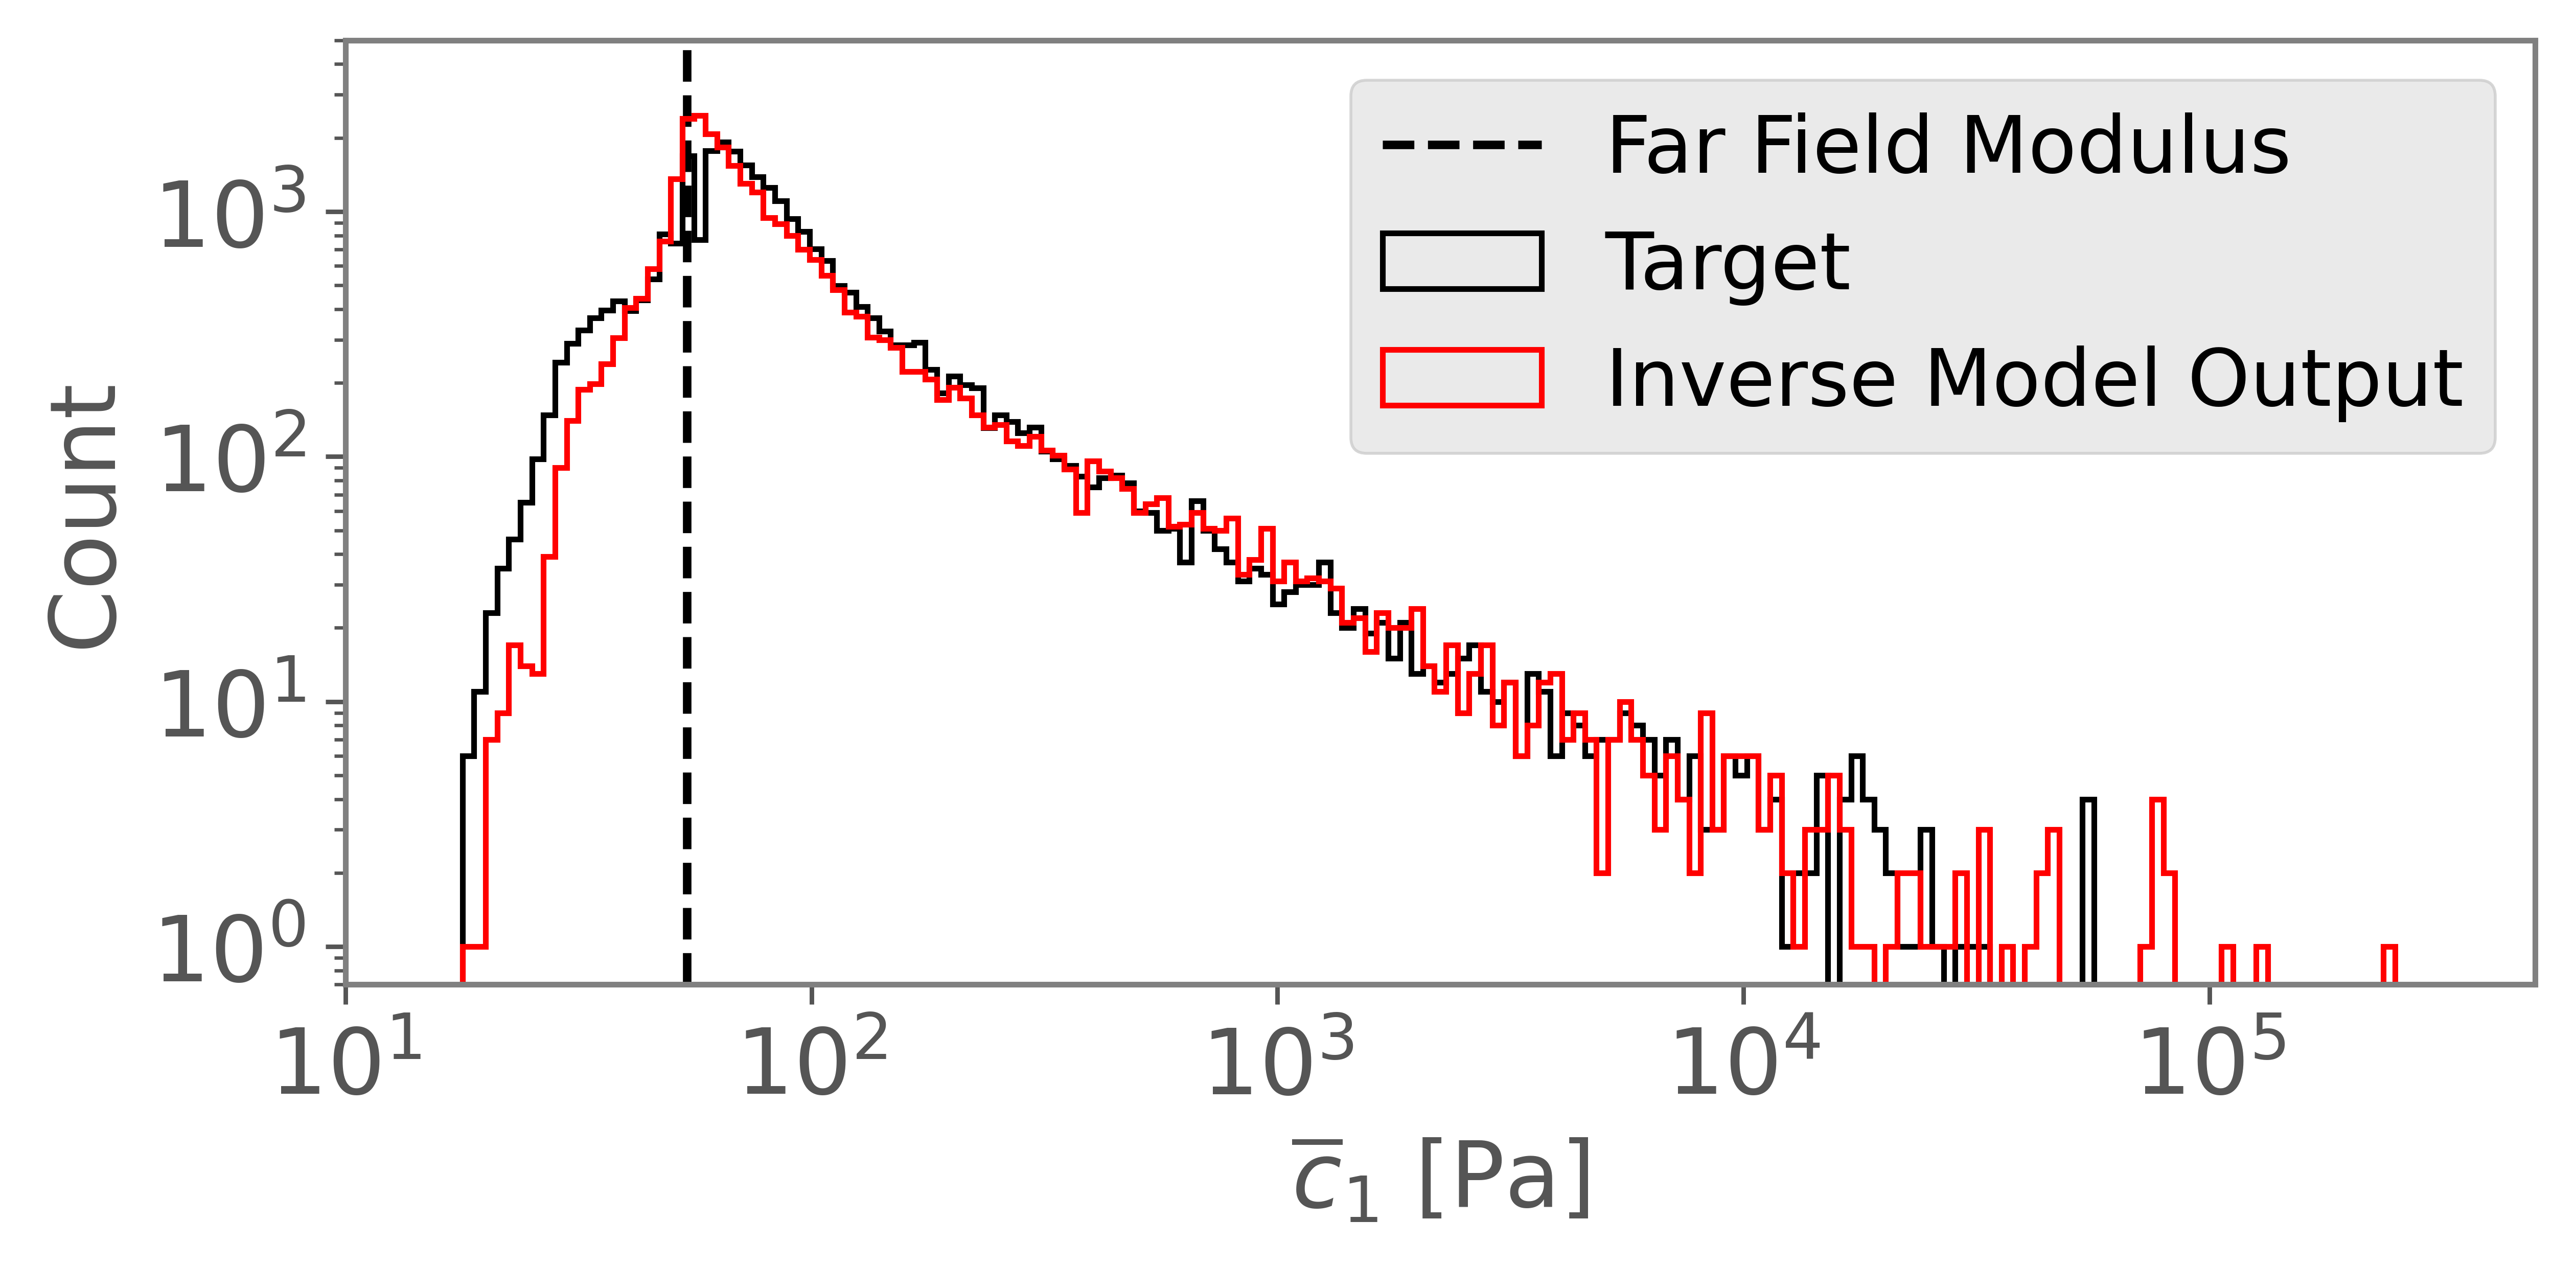

In [29]:
# Compare
bincount = int(np.sqrt(veh_mask.sum()))
tar_beta_select = tar_point_data["mod_repr"][veh_mask]+np.log(54)
sim_beta_select = sim_point_data["mod_repr"][veh_mask]+np.log(54)
beta_range = (min(sim_beta_select.min(), tar_beta_select.min()), np.log(2.5e5))
plt.plot([np.log(54), np.log(54)], [0.7, 5e3], "--", c="k", label="Far Field Modulus")
plt.hist(tar_beta_select, range=beta_range, color="k", bins=bincount, histtype="step", label="Target", linewidth=1)
plt.hist(sim_beta_select, range=beta_range, color="r", bins=bincount, histtype="step", label="Inverse Model Output", linewidth=1)
xtick_pos = np.array([1, 2, 3, 4, 5, 6, 7])
xtick_label = [r"$10^{"f"{x}"r"}$" for x in xtick_pos]
plt.xticks(xtick_pos*np.log(10), xtick_label)
plt.yscale("log")
#plt.suptitle(r"Nodal Modulus Values in Event Horizon", fontsize=20)
plt.xlabel(r"$\overline{c}_1$ [Pa]")
plt.ylabel(r"Count")
plt.xlim(np.log(10), np.log(5e5))
plt.ylim(0.7, 5e3)
plt.legend(fontsize=14)
plt.gcf().set_size_inches(6.4, 3.2)

plt.tight_layout()
ax = plt.gca()
ax.set_facecolor("w")
grid_color = "grey"
#plt.grid(c=grid_color)
for sp in "left right top bottom".split():
    ax.spines[sp].set_color(grid_color)
    
#plt.savefig(FILENAME)
plt.show()

In [30]:
# Count outliers excluded by above
outlier_count = (sim_point_data["mod_repr"].flatten()>np.log(5e5/100)).sum()
print(f"Simulated beta outliers excluded: {outlier_count}")

Simulated beta outliers excluded: 3


In [31]:
# Errors in kinematics
u_sim = kin_sim.u.vector().get_local().reshape(-1, 3)
u_tar_with_noise = kin_tar_with_noise.u.vector().get_local().reshape(-1, 3)
max_u_diff = np.linalg.norm(u_tar_with_noise - u_sim, axis=-1).max()
print(f"Maximum nodal error in u: {max_u_diff} um")

Maximum nodal error in u: 0.46634867852795053 um


In [32]:
J_sim = kin_sim.projected_J
avg_J_err = np.abs(J_sim.vector().get_local() - J_tar_with_noise.vector().get_local()).mean()
print(f"Average error in J: {avg_J_err}")

Average error in J: 0.006079029918403768


In [33]:
def get_traction_mesh(geo, traction_func):
    cell_surf_mesh = meshio.read(os.path.join(test_dir, "cell_surf_with_normal.vtk"))
    fenics_pi_of_surf = np.argmin(cdist(cell_surf_mesh.points, geo.V0.tabulate_dof_coordinates()), axis=-1)
    cell_surf_mesh.point_data["t"] = traction_func.vector().get_local().reshape(-1, 3)[fenics_pi_of_surf]
    signed_traction = 1000*np.sign(np.einsum("ij,ij->i", cell_surf_mesh.point_data["t"], cell_surf_mesh.point_data["n"]))*np.linalg.norm(cell_surf_mesh.point_data["t"], axis=-1) # in kPa
    cell_surf_mesh.point_data["st"] = signed_traction
    return cell_surf_mesh

In [34]:
# Tractions
t_tar = mech_tar.get_nodal_traction()
save_fenics_fcn_nodally(t_tar, os.path.join(test_dir, "traction_tar.xdmf"), "t")
csm_tar = get_traction_mesh(geo, t_tar)

In [35]:
t_sim = mech_sim.get_nodal_traction()
save_fenics_fcn_nodally(t_sim, os.path.join(test_dir, "traction_sim.xdmf"), "t")
csm_sim = get_traction_mesh(geo, t_sim)

In [36]:
signed_traction = csm_sim.point_data["st"]
keepfraction=0.95
exc_count = int(np.floor(len(signed_traction)*(1-keepfraction)/2)) + 1

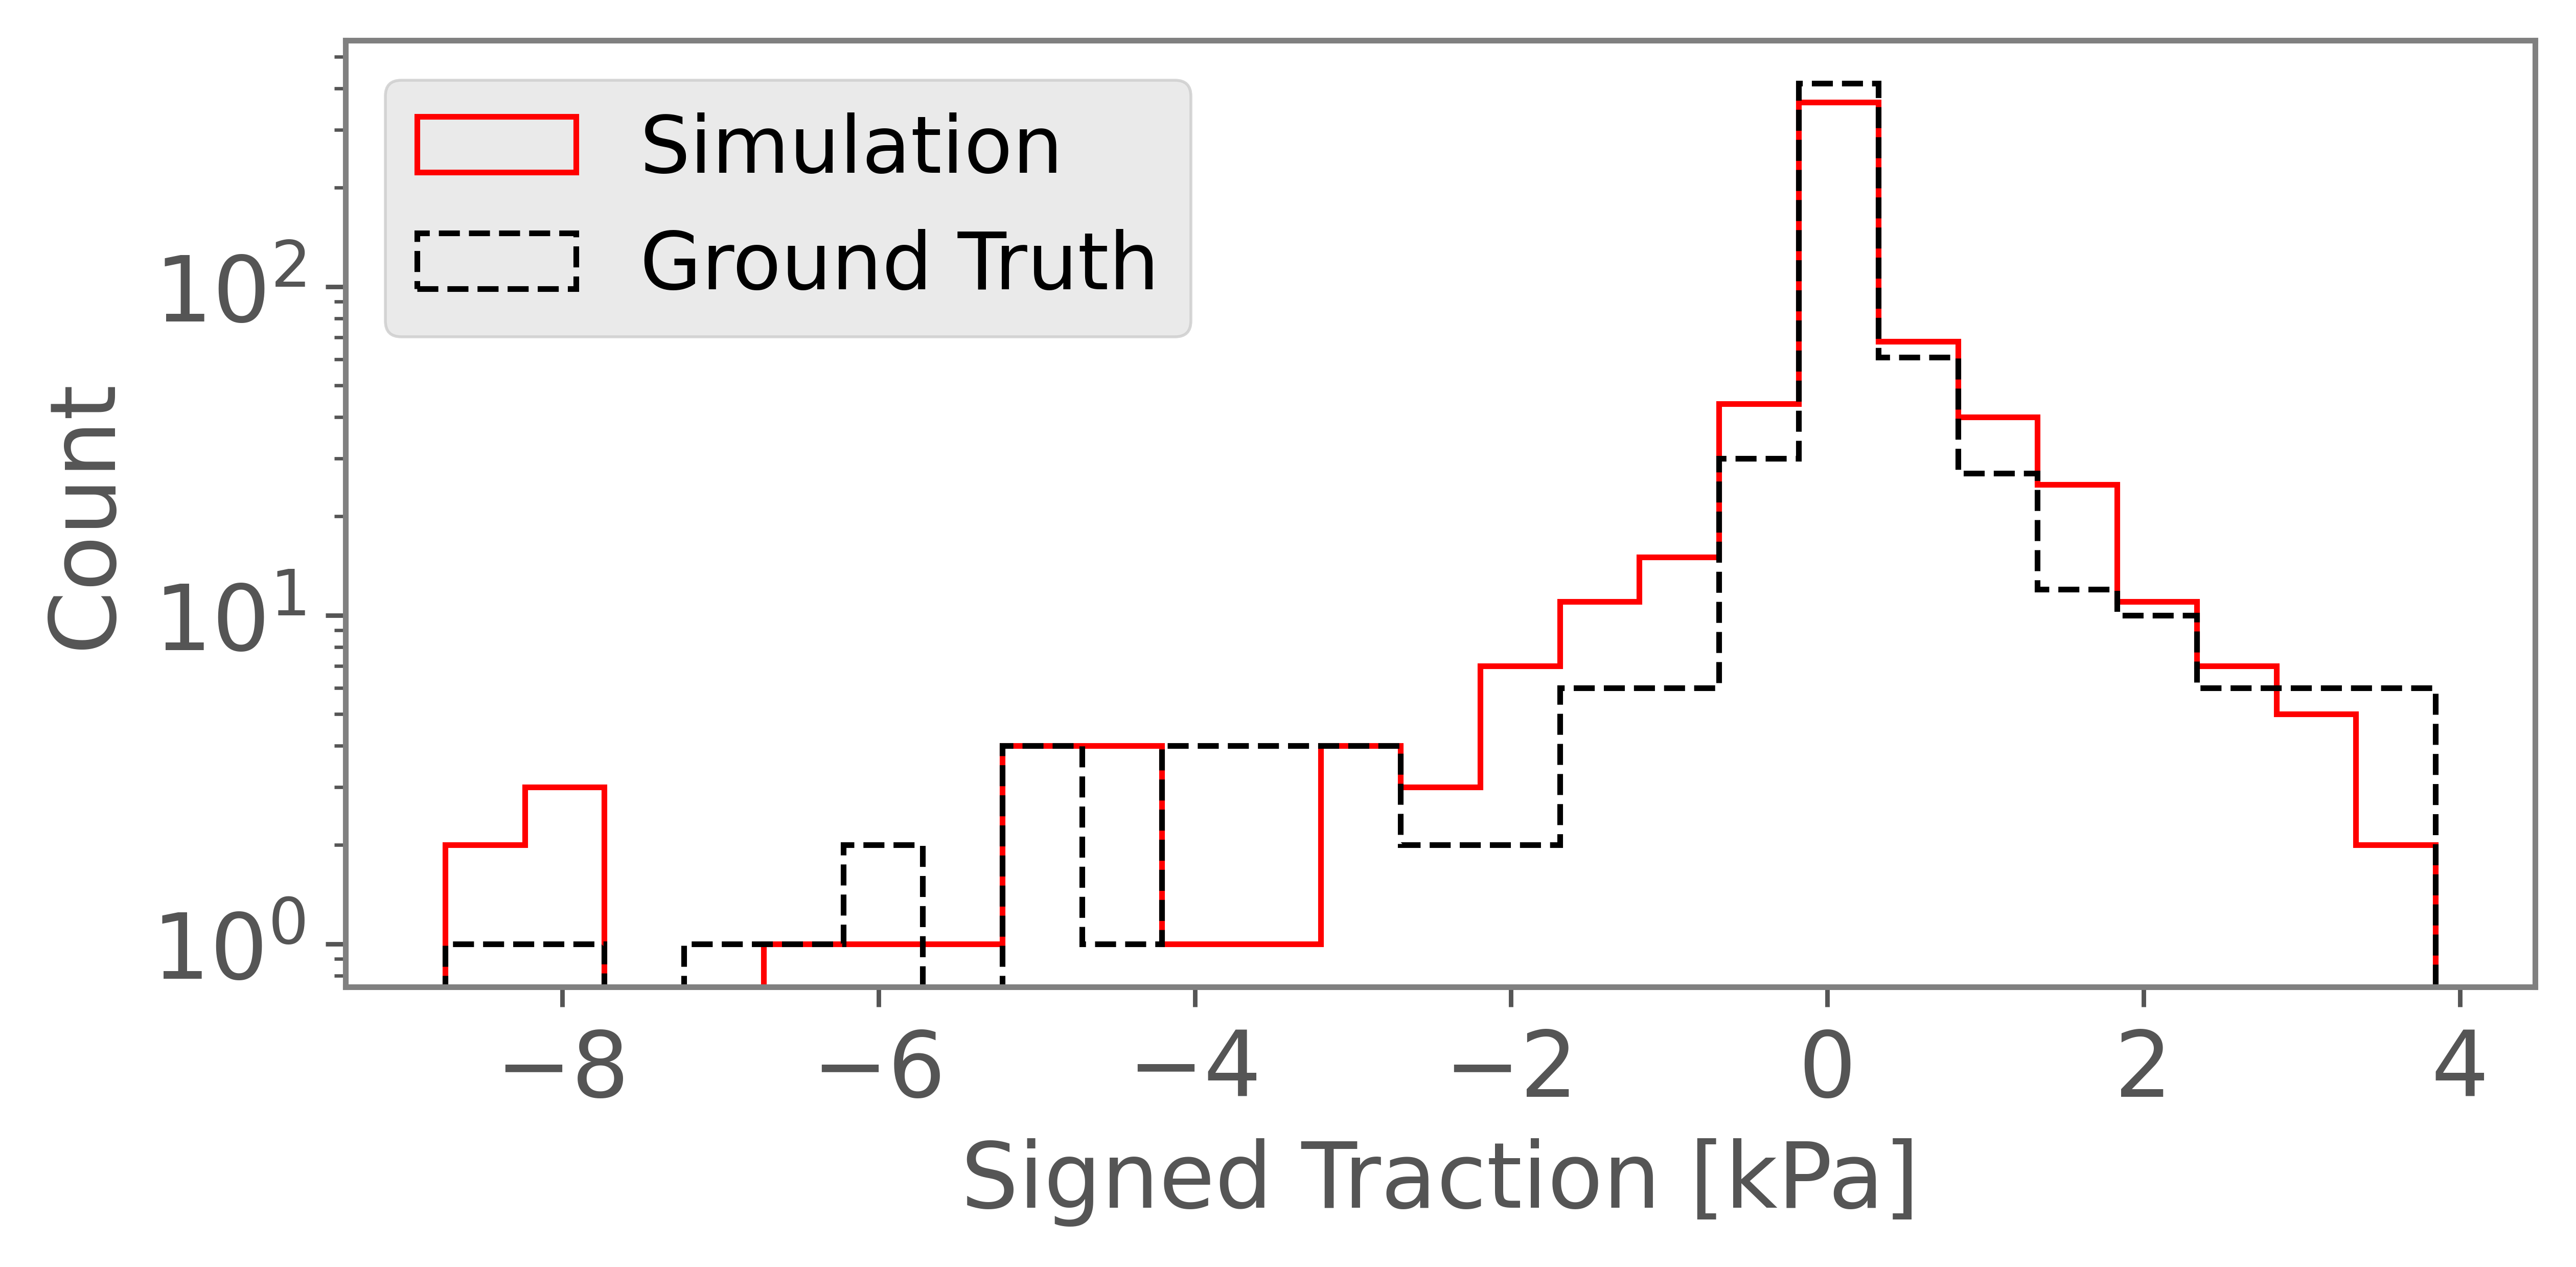

In [37]:
# Traction plot
bincount = int(np.sqrt(len(signed_traction)))
maxval = signed_traction[np.argpartition(signed_traction, -exc_count)[-exc_count:]][0]
minval = signed_traction[np.argpartition(signed_traction, exc_count)[:exc_count]][-1]
histrange=(minval, maxval)
plt.hist(signed_traction, bins=bincount, histtype="step", color="r", range=histrange, linewidth=1, label="Simulation")
plt.hist(csm_tar.point_data["st"], bins=bincount, histtype="step", color="k", range=histrange, linewidth=1, linestyle="dashed", label="Ground Truth")
plt.yscale("log")
plt.legend(loc="upper left", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Signed Traction [kPa]")
plt.gcf().set_size_inches(6.4, 3.2)
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor("w")
grid_color = "grey"
#plt.grid(c=grid_color)
for sp in "left right top bottom".split():
    ax.spines[sp].set_color(grid_color)

#plt.savefig(FILENAME)
plt.show()

In [38]:
mean_rel_err = assemble(abs(1 - exp(beta_sim-beta_tar))*geo.dx(geo.DETECTABLE_U))/assemble(1*geo.dx(geo.DETECTABLE_U))
print(f"Mean relative error in modulus: {mean_rel_err*100}%")

Mean relative error in modulus: 17.247122890843794%


In [39]:
# Read in target J
tar_xdmf = os.path.join("noisy_target_test", "kinematics_tar.xdmf")
tar_mesh = nodal_values_to_meshio(tar_xdmf)
tar_points, tar_cells, tar_point_data, tar_cell_data = \
    tar_mesh.points, tar_mesh.cells, tar_mesh.point_data, tar_mesh.cell_data

In [40]:
# Read in simulated J
sim_xdmf = os.path.join("noisy_target_test", "kinematics_sim.xdmf")
sim_mesh = nodal_values_to_meshio(sim_xdmf)
sim_points, sim_cells, sim_point_data, sim_cell_data = \
    sim_mesh.points, sim_mesh.cells, sim_mesh.point_data, sim_mesh.cell_data

In [41]:
veh_mask_cell = (veh_mesh.cell_data["f"][0] == 251)

In [42]:
select_J_tar = tar_cell_data["J"][0].flatten()[veh_mask_cell]
stdJ = select_J_tar.std()
print(f"Standard deviation of target J in event horizon: {stdJ}")

Standard deviation of target J in event horizon: 0.03857124750708444


In [43]:
select_J_sim = sim_cell_data["J"][0].flatten()[veh_mask_cell]
stdJ = select_J_sim.std()
print(f"Standard deviation of predicted J in event horizon: {stdJ}")

Standard deviation of predicted J in event horizon: 0.037710757782284214


## Mismatched Compressibility

Run stage 1 for both cases:

    nohup mpirun -n 2 inverse -r noisy_test_results -c cell_data_A -t noisy_target_test/u_exp_1000.xdmf --bci noisy_target_test/bci.vtk --bco noisy_target_test/bco.vtk -g 10.0 -k 10 | tee -a out.txt &
    nohup mpirun -n 2 inverse -r noisy_test_results -c cell_data_A -t noisy_target_test/u_exp_1000.xdmf --bci noisy_target_test/bci.vtk --bco noisy_target_test/bco.vtk -g 10.0 -k 100 | tee -a out.txt &
    
Stage 2 for both cases (note the -i argument can be changed to the output of the previous stage instead of the original run):

    nohup mpirun -n 2 inverse -r noisy_test_results -c cell_data_A -t noisy_target_test/u_exp_1000.xdmf --bci noisy_target_test/bci.vtk --bco noisy_target_test/bco.vtk -k 10 -i noisy_target_test/beta_sim_k10_1.xdmf | tee -a out.txt &
    nohup mpirun -n 2 inverse -r noisy_test_results -c cell_data_A -t noisy_target_test/u_exp_1000.xdmf --bci noisy_target_test/bci.vtk --bco noisy_target_test/bco.vtk -k 100 -i noisy_target_test/beta_sim_k100_1.xdmf | tee -a out.txt &

Obtain kinematic quantites for final result:

    get_kinematics_mesh -c cell_data_A -i noisy_target_test/u_sim_k10/u_cg2.xdmf -o noisy_target_test/kinematics_sim_k10.xdmf
    get_kinematics_mesh -c cell_data_A -i noisy_target_test/u_sim_k100/u_cg2.xdmf -o noisy_target_test/kinematics_sim_k100.xdmf

Alternatively, use resuls given in noisy_target_test.

Analysis, continuing from the section above:

In [44]:
# Load predicted kinematics, modulus
kin_sim_10 = kinematics_from_file(geo, os.path.join(test_dir, "u_sim_k10", "u_cg2.xdmf"))
kin_sim_100 = kinematics_from_file(geo, os.path.join(test_dir, "u_sim_k100", "u_cg2.xdmf"))

In [45]:
beta_sim_10 = load_shape(geo.V0, os.path.join(test_dir, "beta_sim_k10_2.xdmf"), "mod_repr")
beta_sim_100 = load_shape(geo.V0, os.path.join(test_dir, "beta_sim_k100_2.xdmf"), "mod_repr")

In [46]:
# Energy
mech_sim_10 = Mechanics(kin_sim_10, d1c1=10, mod_repr=beta_sim_10)
energy_sim_10 = mech_sim_10.get_total_strain_energy()
print(f"Predicted energy with D1/C1=10: {energy_sim_10} pJ")

Predicted energy with D1/C1=10: 34.756915967626206 pJ


In [47]:
mech_sim_100 = Mechanics(kin_sim_100, d1c1=100, mod_repr=beta_sim_100)
energy_sim_100 = mech_sim_100.get_total_strain_energy()
print(f"Predicted energy with D1/C1=100: {energy_sim_100} pJ")

Predicted energy with D1/C1=100: 333.9182207550744 pJ


In [48]:
# Volumes
stiff_vol_sim_10 = assemble(ufl.conditional(ufl.gt(beta_sim_10, np.log(10)), 1.0, 0.0)*geo.dx)
stiff_vol_sim_100 = assemble(ufl.conditional(ufl.gt(beta_sim_100, np.log(10)), 1.0, 0.0)*geo.dx)
print(f"Predicted stiffened volume with D1/C1=10: {stiff_vol_sim_10}")
print(f"Predicted stiffened volume with D1/C1=100: {stiff_vol_sim_100}")

Predicted stiffened volume with D1/C1=10: 319262.98738333274
Predicted stiffened volume with D1/C1=100: 863788.7046104776


In [49]:
deg_vol_sim_10 = assemble(ufl.conditional(ufl.lt(beta_sim_10, np.log(0.99)), 1.0, 0.0)*geo.dx)
deg_vol_sim_100 = assemble(ufl.conditional(ufl.lt(beta_sim_100, np.log(0.99)), 1.0, 0.0)*geo.dx)
print(f"Predicted degraded volume with D1/C1=10: {deg_vol_sim_10}")
print(f"Predicted degraded volume with D1/C1=100: {deg_vol_sim_100}")

Predicted degraded volume with D1/C1=10: 76180.6739361824
Predicted degraded volume with D1/C1=100: 91998.33641945783


In [50]:
mean_rel_err_10 = assemble(abs(1 - exp(beta_sim_10-beta_tar))*geo.dx(geo.DETECTABLE_U))/assemble(1*geo.dx(geo.DETECTABLE_U))
mean_rel_err_100 = assemble(abs(1 - exp(beta_sim_100-beta_tar))*geo.dx(geo.DETECTABLE_U))/assemble(1*geo.dx(geo.DETECTABLE_U))
print(f"Mean relative error in modulus D1/C1=10: {mean_rel_err_10*100}%")
print(f"Mean relative error in modulus D1/C1=100: {mean_rel_err_100*100}%")

Mean relative error in modulus D1/C1=10: 415.00398067428785%
Mean relative error in modulus D1/C1=100: 6651.285427638444%


In [51]:
u_10 = kin_sim_10.u.vector().get_local().reshape(-1, 3)
max_u_diff_10 = np.linalg.norm(u_tar_with_noise - u_10, axis=-1).max()
print(f"Maximum nodal error in u, D1/C1=10: {max_u_diff_10} um")
u_100 = kin_sim_100.u.vector().get_local().reshape(-1, 3)
max_u_diff_100 = np.linalg.norm(u_tar_with_noise - u_100, axis=-1).max()
print(f"Maximum nodal error in u, D1/C1=100: {max_u_diff_100} um")

Maximum nodal error in u, D1/C1=10: 0.5615699655864562 um
Maximum nodal error in u, D1/C1=100: 1.1486462770360144 um


In [52]:
J_10 = kin_sim_10.projected_J
avg_J_err_10 = np.abs(J_10.vector().get_local() - J_tar_with_noise.vector().get_local()).mean()
print(f"Average error in J, D1/C1=10: {avg_J_err_10}")
J_100 = kin_sim_100.projected_J
avg_J_err_100 = np.abs(J_100.vector().get_local() - J_tar_with_noise.vector().get_local()).mean()
print(f"Average error in J, D1/C1=100: {avg_J_err_100}")

Average error in J, D1/C1=10: 0.007847806870607285
Average error in J, D1/C1=100: 0.010014091449996777


In [53]:
# Read in tar
comparable_tar_xdmf = "noisy_target_test/beta_tar_nodal.xdmf"
tar_mesh = nodal_values_to_meshio(comparable_tar_xdmf)
tar_points, tar_cells, tar_point_data, tar_cell_data = \
    tar_mesh.points, tar_mesh.cells, tar_mesh.point_data, tar_mesh.cell_data

In [54]:
# Read in sim10
sim10_xdmf = os.path.join(test_dir, "beta_sim_k10_2_nodal.xdmf")
save_fenics_fcn_nodally(beta_sim_10, sim10_xdmf, "mod_repr")
sim10_mesh = nodal_values_to_meshio(sim10_xdmf)
sim10_points, sim10_cells, sim10_point_data, sim10_cell_data = \
    sim10_mesh.points, sim10_mesh.cells, sim10_mesh.point_data, sim10_mesh.cell_data

In [55]:
# Read in sim100
sim100_xdmf = os.path.join(test_dir, "beta_sim_k100_2_nodal.xdmf")
save_fenics_fcn_nodally(beta_sim_100, sim100_xdmf, "mod_repr")
sim100_mesh = nodal_values_to_meshio(sim100_xdmf)
sim100_points, sim100_cells, sim100_point_data, sim100_cell_data = \
    sim100_mesh.points, sim100_mesh.cells, sim100_mesh.point_data, sim100_mesh.cell_data

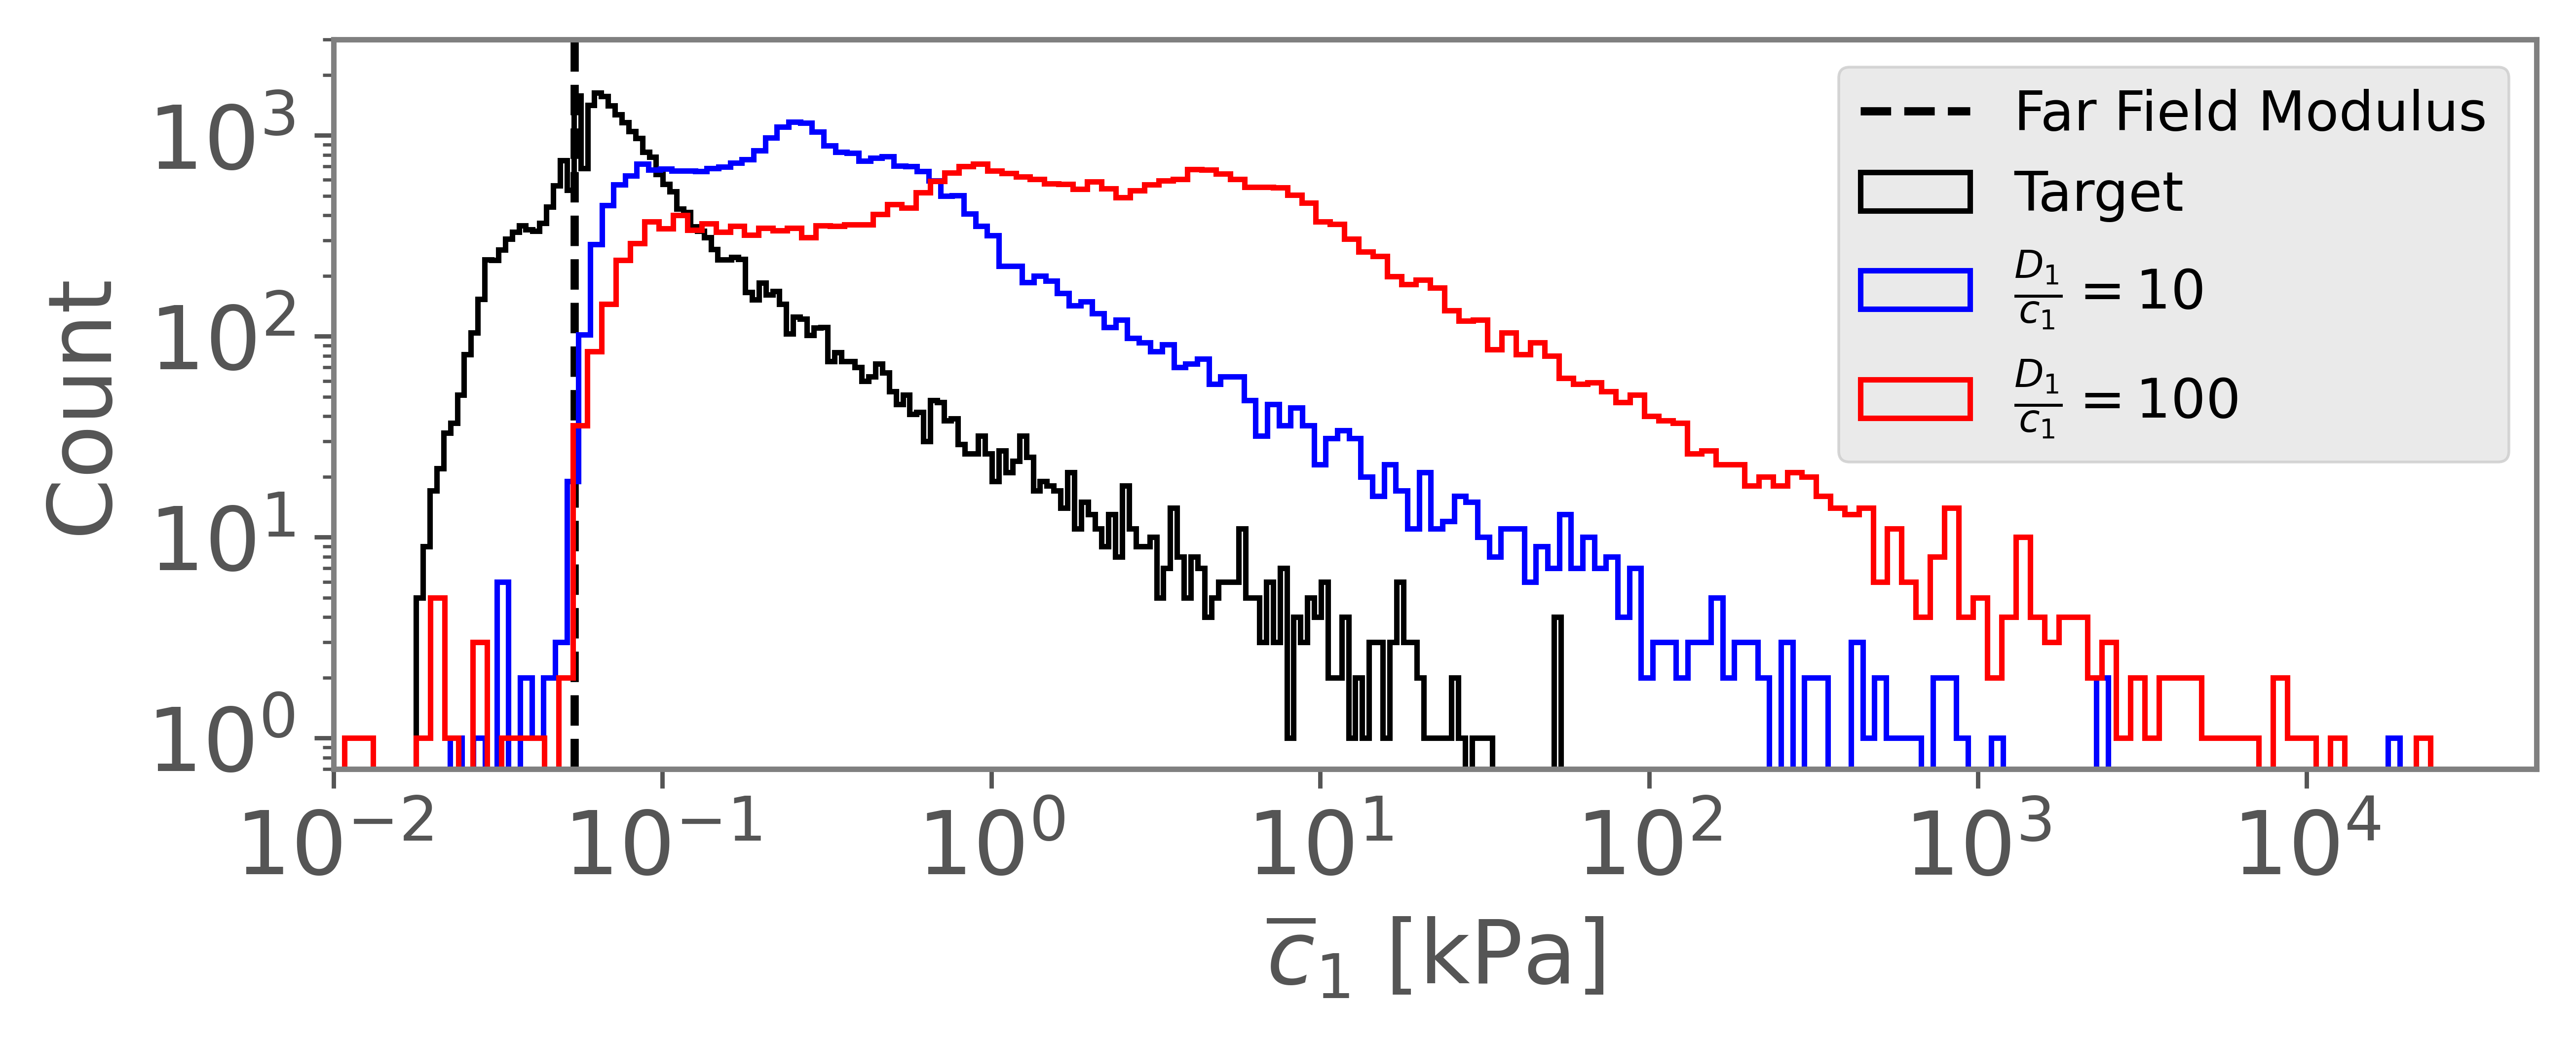

In [56]:
bincount = int(np.sqrt(veh_mask.sum()))
tar_beta_select = tar_point_data["mod_repr"][veh_mask]+np.log(54)
sim10_beta_select = sim10_point_data["mod_repr"][veh_mask]+np.log(54)
sim100_beta_select = sim100_point_data["mod_repr"][veh_mask]+np.log(54)
plt.plot([np.log(54), np.log(54)], [0.7, 3e3], "--", c="k", label="Far Field Modulus")
plt.hist(tar_beta_select, color="k", bins=bincount, histtype="step", label="Target", linewidth=1)
plt.hist(sim10_beta_select, color="b", bins=bincount, histtype="step", label=r"$\frac{D_1}{c_1}=10$", linewidth=1)
plt.hist(sim100_beta_select, color="r", bins=bincount, histtype="step", label=r"$\frac{D_1}{c_1}=100$", linewidth=1)
xtick_pos = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
xtick_label = [r"$10^{"f"{x-3}"r"}$" for x in xtick_pos]
plt.xticks(xtick_pos*np.log(10), xtick_label)
plt.yscale("log")
#plt.suptitle(r"Nodal Modulus Values in Event Horizon", fontsize=20)
plt.xlabel(r"$\overline{c}_1$ [kPa]")
plt.ylabel(r"Count")
plt.xlim(np.log(10), np.log(5e7))
plt.ylim(0.7, 3e3)
plt.legend(fontsize=10)
plt.gcf().set_size_inches(7.2, 7.2/3)

ax = plt.gca()
ax.set_facecolor("w")
grid_color = "grey"
#plt.grid(c=grid_color)
for sp in "left right top bottom".split():
    ax.spines[sp].set_color(grid_color)
    
#plt.savefig(FILENAME)
plt.show()

In [57]:
t_10 = mech_sim_10.get_nodal_traction()
save_fenics_fcn_nodally(t_10, os.path.join(test_dir, "traction_10.xdmf"), "t")
csm_10 = get_traction_mesh(geo, t_10)
t_100 = mech_sim_100.get_nodal_traction()
save_fenics_fcn_nodally(t_100, os.path.join(test_dir, "traction_100.xdmf"), "t")
csm_100 = get_traction_mesh(geo, t_100)

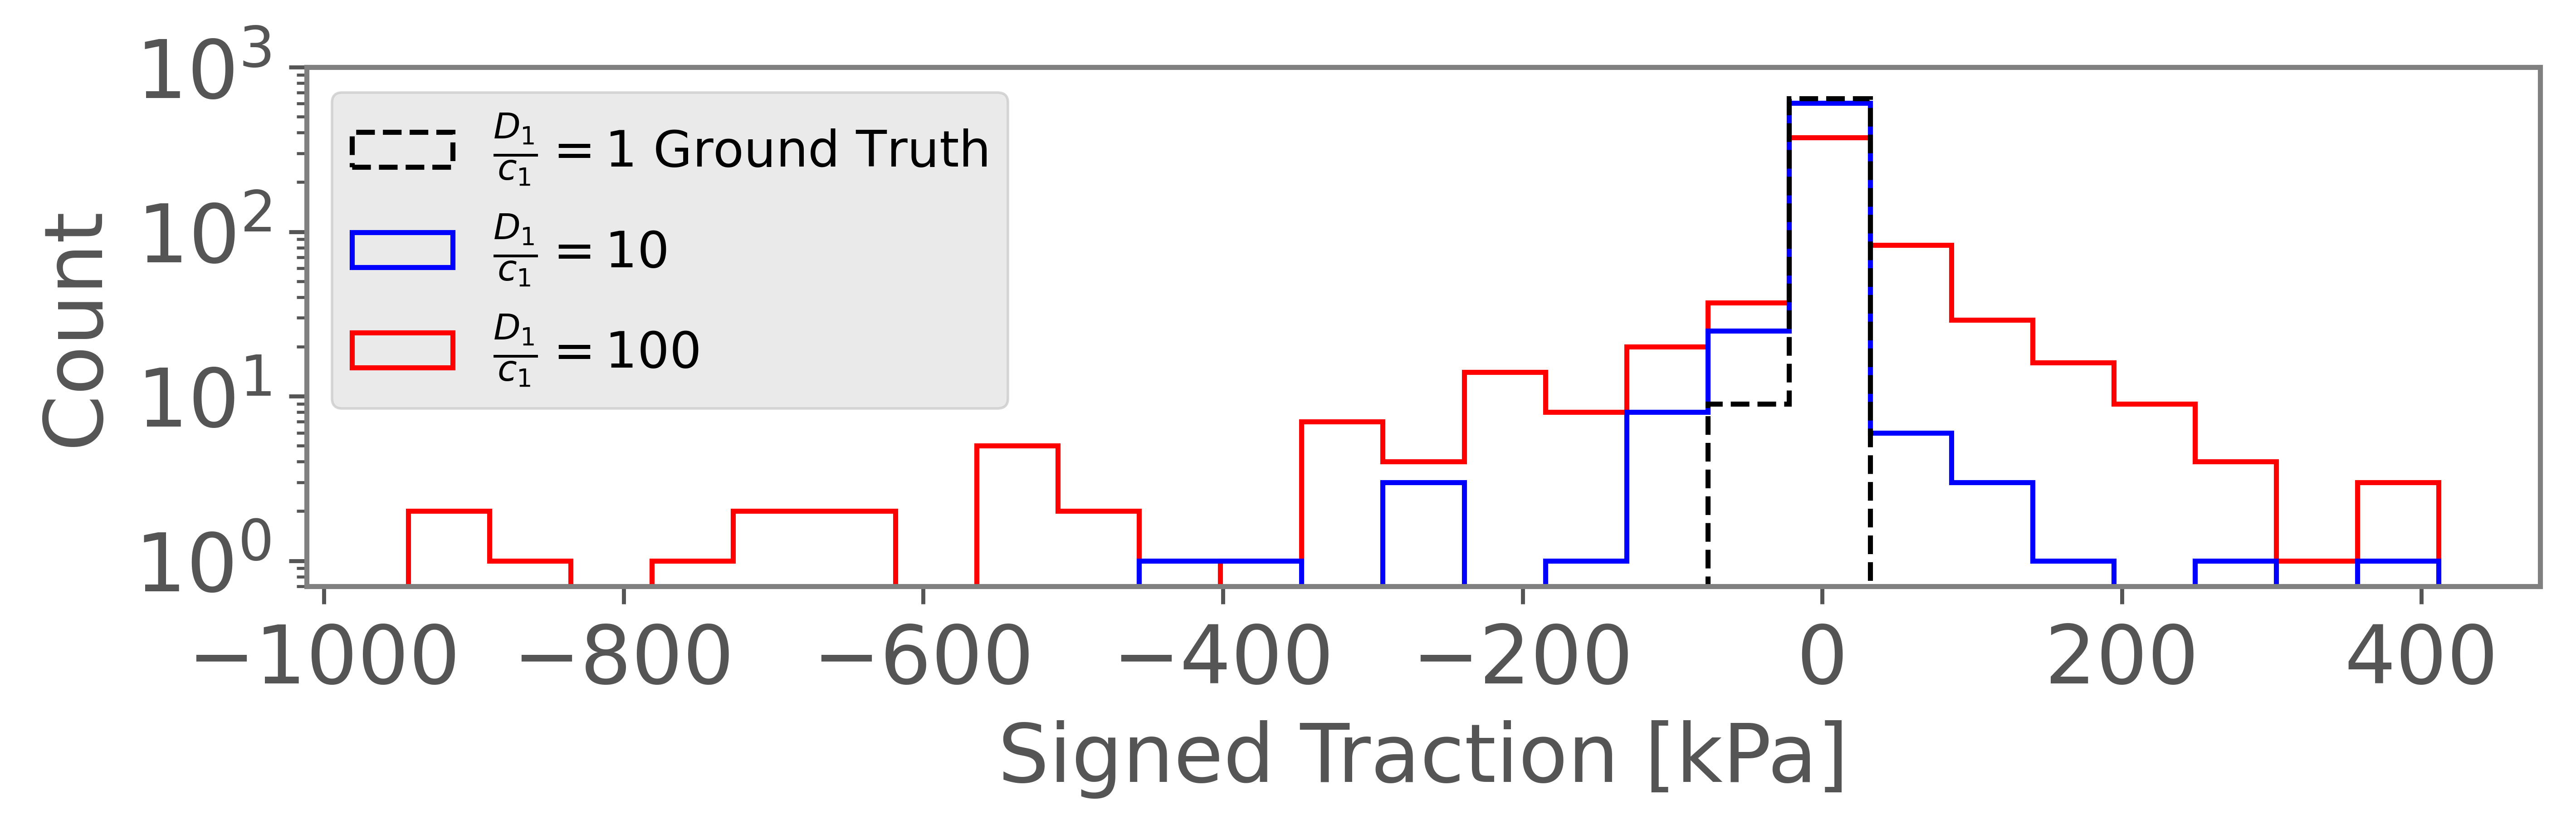

In [58]:
bincount = int(np.sqrt(len(signed_traction)))

maxval = -np.inf
minval = np.inf
for st_vec in [csm_tar.point_data["st"], csm_10.point_data["st"], csm_100.point_data["st"]]:
    maxval = max(maxval, st_vec[np.argpartition(st_vec, -exc_count)[-exc_count:]][0])
    minval = min(minval, st_vec[np.argpartition(st_vec, exc_count)[:exc_count]][-1])
histrange=(minval, maxval)

plt.hist(csm_100.point_data["st"], bins=bincount, histtype="step", color="r", range=histrange, linewidth=1, label=r"$\frac{D_1}{c_1}=100$")
plt.hist(csm_10.point_data["st"], bins=bincount, histtype="step", color="b", range=histrange, linewidth=1, linestyle="-", label=r"$\frac{D_1}{c_1}=10$")
plt.hist(csm_tar.point_data["st"], bins=bincount, histtype="step", color="k", range=histrange, linewidth=1, linestyle="dashed", label=r"$\frac{D_1}{c_1}=1$ Ground Truth")
plt.yscale("log")
plt.ylim(0.7, 1e3)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="upper left", fontsize=10)
plt.ylabel("Count")
plt.xlabel("Signed Traction [kPa]")
plt.gcf().set_size_inches(7.2, 7.2/3)
plt.tight_layout()
ax.set_facecolor("w")
grid_color = "grey"
for sp in "left right top bottom".split():
    ax.spines[sp].set_color(grid_color)

#plt.savefig(FILENAME)
plt.show()

In [59]:
tn_tar = csm_tar.point_data["t"]
tn_1 = csm_sim.point_data["t"]
tn_10 = csm_10.point_data["t"]
tn_100 = csm_100.point_data["t"]

offset = int(len(tn_tar)*(1 - 0.95)/2)

tn_diff_1 = np.sort(np.linalg.norm(tn_tar - tn_1, axis=-1))[offset:-offset]
tn_mrmse_1 = np.sqrt(tn_diff_1.mean())
print(
    f"Root mean squared error of median 95% of nodal tractions D1/C1=1: "
    f"{tn_mrmse_1} kPa"
)

tn_diff_10 = np.sort(np.linalg.norm(tn_tar - tn_10, axis=-1))[offset:-offset]
tn_mrmse_10 = np.sqrt(tn_diff_10.mean())
print(
    f"Root mean squared error of median 95% of nodal tractions D1/C1=10: "
    f"{tn_mrmse_10} kPa"
)

tn_diff_100 = np.sort(np.linalg.norm(tn_tar - tn_100, axis=-1))[offset:-offset]
tn_mrmse_100 = np.sqrt(tn_diff_100.mean())
print(
    f"Root mean squared error of median 95% of nodal tractions D1/C1=100: "
    f"{tn_mrmse_100} kPa"
)

print(
    f"Max increase in root mean squared error of median 95% of nodal tractions: "
    f"{tn_mrmse_100/tn_mrmse_1}"
)

Root mean squared error of median 95% of nodal tractions D1/C1=1: 0.029265909755569246 kPa
Root mean squared error of median 95% of nodal tractions D1/C1=10: 0.0761932923763995 kPa
Root mean squared error of median 95% of nodal tractions D1/C1=100: 0.2938442167982872 kPa
Max increase in root mean squared error of median 95% of nodal tractions: 10.040494871080138
